##HPK Electricity

This notebook will extract typical profiles for use as input for the coupled co-simulation with CitySim

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline 

In [3]:
workingdir = "/Users/millerc/Dropbox/03-ETH/98-UMEM/RawDataAnalysis/"

In [4]:
# os.chdir(workingdir)

In [5]:
df = pd.read_csv(workingdir+"aggset2_QW/HPK_QW.csv", index_col="Date Time", parse_dates=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70201 entries, 2006-01-07 00:00:00 to 2014-01-10 00:00:00
Data columns (total 10 columns):
HPKMEL01QW_A [kWh]    70169 non-null float64
HPKMEL98QW_A [kWh]    70169 non-null float64
HPKMEL99QW_A [kWh]    70169 non-null float64
HPKMHE01QW_A [kWh]    70169 non-null float64
HPKMHE95QW_A [kWh]    70169 non-null float64
HPKMHE97QW_A [kWh]    70169 non-null float64
HPKMHE99QW_A [kWh]    70169 non-null float64
HPKMKA01QW_A [kWh]    70169 non-null float64
HPKMKA98QW_A [kWh]    70169 non-null float64
HPKMKA99QW_A [kWh]    70169 non-null float64
dtypes: float64(10)
memory usage: 5.9 MB


In [9]:
point = "HPKMHE01QW_A [kWh]"

In [10]:
df_QW = pd.DataFrame(df[point].truncate(before='2013',after='2014'))

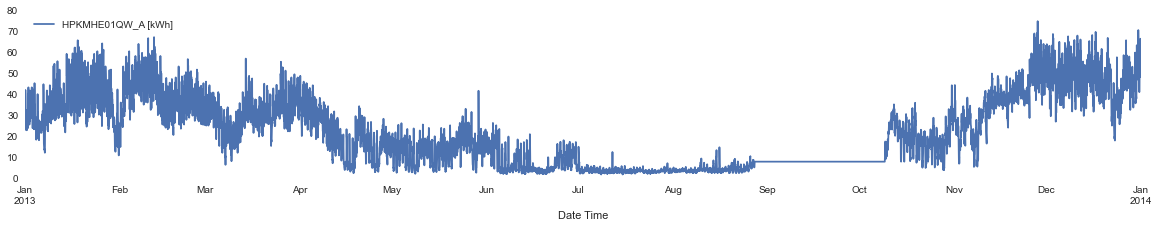

In [11]:
df_QW.plot(figsize=(20,3));

##Convert to SAX

In [12]:
df = df_QW.dropna()

In [13]:
#df.head()

In [14]:
df['Date'] = df.index.map(lambda t: t.date())
df['Time'] = df.index.map(lambda t: t.time())

/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/millerc/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [15]:
df_pivot = pd.pivot_table(df, values=point, index='Date', columns='Time')

In [16]:
a = 3
w = '4h'

In [17]:
from scipy.stats import norm
import numpy as np
import string

In [18]:
def discretizer(row, breakpoints):
    return np.where(breakpoints > float(row))[0][0]

def stringizer(row):
    return ''.join(string.ascii_letters[int(row['step'])])

def adddate(df):
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    return df

def SAXizer(df, symbol_count, breakfreq):
    x = df.fillna(method='ffill')
    y = (x - x.mean()) / x.std()
    z = pd.DataFrame(y.resample(breakfreq).dropna())
    z.columns = ["numbers"]
    breakpoints = norm.ppf(np.linspace(1./symbol_count, 1-1./symbol_count, symbol_count-1))
    breakpoints = np.concatenate((breakpoints, np.array([np.Inf])))
    
    z['step'] = z.apply(discretizer, axis=1, args=[breakpoints])
    z['letter'] = z.apply(stringizer, axis=1)
    z = adddate(z)
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    zpivot = z.pivot(index='Date', columns='Time', values='letter')
    
    SAXstrings = zpivot.dropna().sum(axis=1)
    
    return zpivot.dropna(), SAXstrings

In [19]:
df_forSAX = df[point]
zpivot, SAXstrings = SAXizer(df_forSAX, a, w)

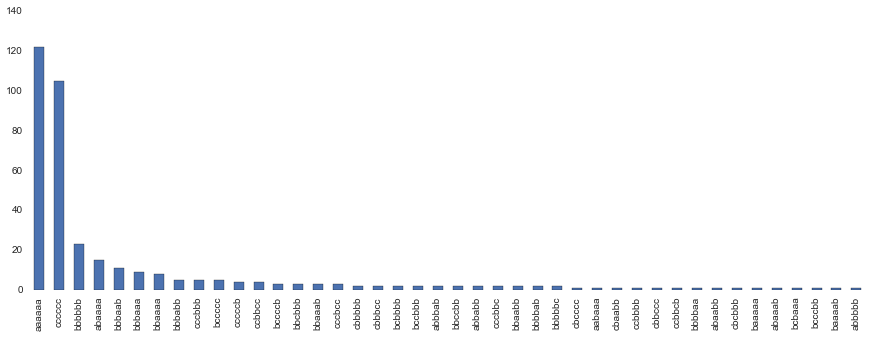

In [20]:
patterncount = SAXstrings.value_counts()
patterncount.plot(kind='bar', figsize=(15,5));

In [21]:
binsizethreshold = 0.02
motifs = patterncount[(patterncount > patterncount.sum() * binsizethreshold)]
motifs

aaaaaa    122
cccccc    105
bbbbbb     23
abaaaa     15
bbbaab     11
bbbaaa      9
bbaaaa      8
dtype: int64

In [22]:
discords = patterncount[(patterncount < patterncount.sum() * binsizethreshold)]
discords.head()

bbbabb    5
cccbbb    5
bccccc    5
cccccb    4
ccbbcc    4
dtype: int64

In [23]:
df_RawAndSAX = pd.concat([df_pivot, pd.DataFrame(SAXstrings, columns=['SAXstring'])], axis=1)

In [24]:
motifdata = df_RawAndSAX[df_RawAndSAX.SAXstring.isin(list(motifs.index))]

#Cluster!

In [25]:
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt


In [26]:
# df = motifdata.drop(['SAXstring'], axis=1)

In [27]:
df_pivot.head()

Time        00:00:00  01:00:00  02:00:00  03:00:00  04:00:00  05:00:00  \
Date                                                                     
2013-01-01     34.25     26.25     32.75     32.75     28.50     42.25   
2013-01-02     24.00     27.75     28.25     25.25     29.75     43.50   
2013-01-03     35.75     35.75     29.00     41.50     40.25     34.25   
2013-01-04     28.50     23.50     28.75     28.25     23.50     45.50   
2013-01-05     19.00     25.75     24.50     20.25     25.00     40.25   

Time        06:00:00  07:00:00  08:00:00  09:00:00    ...     14:00:00  \
Date                                                  ...                
2013-01-01     39.00     31.00     26.25     32.75    ...        23.00   
2013-01-02     28.75     40.75     40.50     32.25    ...        34.00   
2013-01-03     36.50     43.50     33.25     28.75    ...        24.00   
2013-01-04     37.25     25.75     35.25     31.00    ...        24.00   
2013-01-05     23.00     31.00     31.75     22.75    ...        21.75   

Time        15:00:00  16:00:00  17:00:00  18:00:00  19:00:00  20:00:00  \
Date                                                                     
2013-01-01     31.00     32.25     29.50     23.25     28.50     27.75   
2013-01-02     31.50     27.25     42.00     32.50     28.50     32.50   
2013-01-03     40.00     39.25     42.50     24.00     30.25     28.50   
2013-01-04     27.25     29.25     28.75     18.50     25.25     24.75   
2013-01-05     23.00     18.25     27.75     26.25     22.25     24.25   

Time        21:00:00  22:00:00  23:00:00  
Date                                      
2013-01-01     26.25     28.00     28.25  
2013-01-02     33.75     31.25     32.00  
2013-01-03     29.75     25.75     30.25  
2013-01-04     20.00     24.75     25.75  
2013-01-05     25.00     21.75     27.25  

[5 rows x 24 columns]

In [28]:
df = df_pivot

In [29]:
def timestampcombine_parse(date,time):
    #timestampstring = date+" "+time
#     date = datetime.strptime(date, "%Y-%M-%d")
#     time = datetime.strptime(time, "%H:%M:%S").time()
    pydatetime = datetime.combine(date, time)

    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [30]:
df = df.T.unstack().reset_index()
df['timestampstring'] = map(timestampcombine_parse, df.Date, df.Time)
df.index = df.timestampstring
df = df.drop(['Date','Time','timestampstring'],axis=1)
df.columns = [point]
df = df.resample('H')

In [31]:
df.head()

HPKMHE01QW_A [kWh]
timestampstring                        
2013-01-01 00:00:00               34.25
2013-01-01 01:00:00               26.25
2013-01-01 02:00:00               32.75
2013-01-01 03:00:00               32.75
2013-01-01 04:00:00               28.50

In [32]:
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from sklearn import metrics
import numpy as np

In [33]:
df_norm = (df - df.mean()) / (df.max() - df.min()) #normalized

df['Time'] = df.index.map(lambda t: t.time())
df['Date'] = df.index.map(lambda t: t.date())
df_norm['Time'] = df_norm.index.map(lambda t: t.time())
df_norm['Date'] = df_norm.index.map(lambda t: t.date())

In [34]:
dailyblocks = pd.pivot_table(df, values=point, index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(df_norm, values=point, index='Date', columns='Time', aggfunc='mean')

In [35]:
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 4, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [36]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

In [37]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 

In [38]:
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).order()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

In [39]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort()

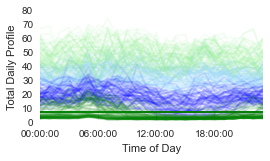

In [40]:
clusterlist = list(dailyclusters.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 4,2

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 21600))

ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day')
plt.savefig("heating_clusters_total_overlaid_profiles.pdf")

In [41]:
def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = map(timestampcombine, df.Date, df.level_2)
    df = df.dropna()
    return df

In [42]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

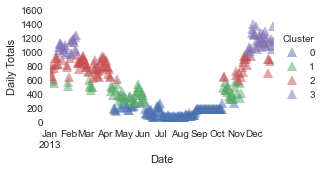

In [43]:
dfclusterunstacked = ClusterUnstacker(dailyclusters)
dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

clusteravgplot = dfclusterunstackedpivoted.resample('D', how=np.sum).plot(style="^",markersize=10, alpha=0.5)
clusteravgplot.set_ylabel('Daily Totals')
clusteravgplot.set_xlabel('Date')
clusteravgplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

plt.savefig("heating_clusters_overtime.pdf")

In [44]:
dailyclusters.head()

ClusterNo2          2                                                         \
Date       2013-01-01 2013-01-02 2013-01-03 2013-01-04 2013-01-06 2013-01-08   
00:00:00        34.25      24.00      35.75      28.50      27.00      27.75   
01:00:00        26.25      27.75      35.75      23.50      22.25      28.50   
02:00:00        32.75      28.25      29.00      28.75      26.25      28.25   
03:00:00        32.75      25.25      41.50      28.25      26.75      30.25   
04:00:00        28.50      29.75      40.25      23.50      24.25      27.75   

ClusterNo2                                                ...              0  \
Date       2013-01-09 2013-01-10 2013-01-11 2013-01-12    ...     2013-10-01   
00:00:00        37.50      35.75      33.50      35.25    ...              8   
01:00:00        27.00      28.50      28.00      28.75    ...              8   
02:00:00        34.50      31.75      34.00      36.00    ...              8   
03:00:00        33.50      37.00      33.75      34.75    ...              8   
04:00:00        29.25      29.25      28.50      29.25    ...              8   

ClusterNo2                                                                    \
Date       2013-10-02 2013-10-03 2013-10-04 2013-10-05 2013-10-06 2013-10-07   
00:00:00            8          8          8          8          8          8   
01:00:00            8          8          8          8          8          8   
02:00:00            8          8          8          8          8          8   
03:00:00            8          8          8          8          8          8   
04:00:00            8          8          8          8          8          8   

ClusterNo2                                   
Date       2013-10-08 2013-10-09 2013-10-28  
00:00:00            8          8     16.500  
01:00:00            8          8     17.625  
02:00:00            8          8      9.875  
03:00:00            8          8     19.375  
04:00:00            8          8     21.000  

[5 rows x 364 columns]

In [45]:
calendar = dfclusterunstackedpivoted.resample('D', how=np.sum)
calendar.head()

ClusterNo2        0    1       2   3
timestampstring                     
2013-01-01      NaN  NaN  715.75 NaN
2013-01-02      NaN  NaN  765.50 NaN
2013-01-03      NaN  NaN  817.00 NaN
2013-01-04      NaN  NaN  662.75 NaN
2013-01-05      NaN  593     NaN NaN

In [46]:
calendar.to_csv("heating_calendar.csv")

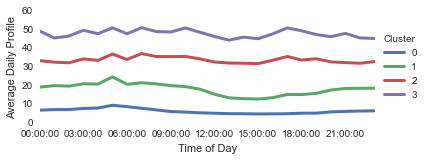

In [47]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(6,2),linewidth=3, xticks=np.arange(0, 86400, 10800))
dailyprofile.set_ylabel('Average Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("heating_clusters_averagedprofiles.pdf")

In [48]:
dfclusterunstackedpivoted.groupby('Time').max().max().max()

75.124999993582591

In [49]:
#dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
normalizedprofiles = dfclusterunstackedpivoted.groupby('Time').mean() / dfclusterunstackedpivoted.groupby('Time').max().max().max()

In [50]:
normalizedprofiles = normalizedprofiles.fillna(0)
normalizedprofiles.plot()

In [51]:
normalizedprofiles.to_csv("heating_Schedules.csv")

In [52]:
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

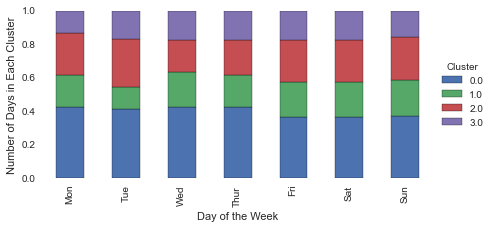

In [53]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
DayVsCluster = DayVsCluster.T/DayVsCluster.T.sum()
DayVsCluster = DayVsCluster.T
DayVsClusterplot1 = DayVsCluster.plot(figsize=(7,3), kind='bar', stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("heating_clusters_dailybreakdown.pdf")

In [107]:
DayVsCluster

ClusterNo2         0         1         2         3
Mon         0.076923  0.519231  0.326923  0.076923
Tue         0.056604  0.245283  0.471698  0.226415
Wed         0.057692  0.173077  0.403846  0.365385
Thur        0.076923  0.250000  0.326923  0.346154
Fri         0.057692  0.442308  0.326923  0.173077
Sat         0.884615  0.096154  0.019231       NaN
Sun         0.901961  0.078431  0.019608       NaN

##Create Graphics for JBPS Paper

First load the resultant data from the analysis so no need to rerun:

In [108]:
normalizedprofiles = pd.read_csv("Schedules.csv", index_col='Time')

In [109]:
normalizedprofiles.head()

0         1         2         3
Time                                            
00:00:00  0.499424  0.524297  0.566745  0.665788
01:00:00  0.496599  0.521304  0.563211  0.659900
02:00:00  0.496506  0.515506  0.560267  0.659675
03:00:00  0.495314  0.515452  0.557847  0.656670
04:00:00  0.496105  0.516557  0.557668  0.653359

In [111]:
dailyprofile = normalizedprofiles.plot(figsize=(4,2),linewidth=3)
dailyprofile.set_ylabel('Normalized Daily Profile')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center', bbox_to_anchor=(0.5, 1.1), title='Cluster', ncol=4)
plt.savefig("clusters_averagedprofiles_normalized.pdf")

###The Cal-Heatmap setup

In [112]:
calendar = pd.read_csv("calendar.csv", index_col='timestampstring', parse_dates=True)

In [113]:
#calendar.fillna(0).dropna(how="all").info()

In [114]:
import time

In [115]:
calendar['epochtime'] = calendar.index.map(lambda x: int(time.mktime(x.timetuple())))
calendar.index = calendar.epochtime

In [116]:
calendar.head()

0   1   2   3   epochtime
epochtime                                  
1356994800  1010.25 NaN NaN NaN  1356994800
1357081200  1033.75 NaN NaN NaN  1357081200
1357167600  1161.00 NaN NaN NaN  1357167600
1357254000  1152.25 NaN NaN NaN  1357254000
1357340400  1057.00 NaN NaN NaN  1357340400

In [117]:
calendar = calendar.drop(['epochtime'], axis=1)

In [118]:
calendar.head()

0   1   2   3
epochtime                      
1356994800  1010.25 NaN NaN NaN
1357081200  1033.75 NaN NaN NaN
1357167600  1161.00 NaN NaN NaN
1357254000  1152.25 NaN NaN NaN
1357340400  1057.00 NaN NaN NaN

In [119]:
cal_heatmap = calendar.unstack().dropna().reset_index()

In [120]:
cal_heatmap.head()

level_0   epochtime        0
0       0  1356994800  1010.25
1       0  1357081200  1033.75
2       0  1357167600  1161.00
3       0  1357254000  1152.25
4       0  1357340400  1057.00

In [121]:
cal_heatmap.index = cal_heatmap.epochtime

In [122]:
cal_heatmap.head()

level_0   epochtime        0
epochtime                              
1356994800       0  1356994800  1010.25
1357081200       0  1357081200  1033.75
1357167600       0  1357167600  1161.00
1357254000       0  1357254000  1152.25
1357340400       0  1357340400  1057.00

In [123]:
cal_heatmap = cal_heatmap.drop(['epochtime',0], axis=1)

In [124]:
cal_heatmap = cal_heatmap.sort()

In [125]:
cal_heatmap.level_0 = cal_heatmap.level_0.astype("float")

In [126]:
cal_heatmap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 1356994800 to 1388444400
Data columns (total 1 columns):
level_0    364 non-null float64
dtypes: float64(1)
memory usage: 5.7 KB


In [127]:
cal_heatmap.head()

level_0
epochtime          
1356994800        0
1357081200        0
1357167600        0
1357254000        0
1357340400        0

In [128]:
cal_heatmap = cal_heatmap+1

In [129]:
cal_heatmap.head()

level_0
epochtime          
1356994800        1
1357081200        1
1357167600        1
1357254000        1
1357340400        1

In [134]:
cal_heatmap.level_0.to_json("hpk_cal_heatmap.json")

In [131]:
x = sns.color_palette()

In [132]:
import matplotlib.colors as colors

In [133]:
for color in x:
    print colors.rgb2hex(color)

#4c72b0
#55a868
#c44e52
#8172b2
#ccb974
#64b5cd
